#[01] Sentiment Analysis with One-Hot Encoding

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import seaborn as sns

# data import
twitter_file = 'Tweets.csv'
df = pd.read_csv(twitter_file).dropna()

df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [ ]:
# get class values based on categories
cat_id = {'neutral':1, 'negative':0, 'positive':2}

df['class'] = df['sentiment'].map(cat_id)

# Hyperparameters
BATCH_SIZE = 512
NUM_EPOCHS = 80

# separate independent and dependent features
X = df['text'].values
y = df['class'].values

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=123)

print(f"X train: {X_train.shape}, y train: {y_train.shape}\nX test: {X_test.shape}, y test: {y_test.shape}")

X train: (13740,), y train: (13740,)
X test: (13740,), y test: (13740,)


In [ ]:
df

,textID,text,selected_text,sentiment,class
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0
2,088c60f138,my boss is bullying me...,bullying me,negative,0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0
...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,0
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,0
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,2
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,2


In [ ]:
one_hot = CountVectorizer()
X_train_onehot = one_hot.fit_transform(X_train)
X_test_onehot = one_hot.transform(X_test)

In [ ]:
X_train_onehot

<13740x17321 sparse matrix of type '<class 'numpy.int64'>'
	with 157703 stored elements in Compressed Sparse Row format>

In [ ]:
X_test_onehot

<13740x17321 sparse matrix of type '<class 'numpy.int64'>'
	with 146479 stored elements in Compressed Sparse Row format>

In [ ]:
# Dataset class
class SentimentData(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = torch.Tensor(X.toarray())
        self.y = torch.Tensor(y).type(torch.LongTensor)
        self.len = len(self.X)

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return self.X[index], self.y[index]

train_ds = SentimentData(X=X_train_onehot, y=y_train)
test_ds = SentimentData(X=X_test_onehot, y=y_test)

In [ ]:
# DataLoader
train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_ds, batch_size=15000)

In [ ]:
# Model
class SentimentModel(nn.Module):
    def __init__(self, NUM_FEATURES, NUM_CLASSES, HIDDEN=10):
        super().__init__()
        self.linear = nn.Linear(NUM_FEATURES, HIDDEN)
        self.linear2 = nn.Linear(HIDDEN, NUM_CLASSES)
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.log_softmax(x)
        return x

In [ ]:
X_train_onehot.shape

(13740, 17321)

In [ ]:
X_test_onehot.shape

(13740, 17321)

In [ ]:
# Model, Loss and Optimizer
model = SentimentModel(NUM_FEATURES=X_train_onehot.shape[1], NUM_CLASSES=3)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())

In [ ]:
# Model Training
train_losses = []

for e in range(NUM_EPOCHS):
    curr_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred_log = model(X_batch)
        loss = criterion(y_pred_log, y_batch.long())

        curr_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_losses.append(curr_loss)
    print(f"Epoch {e}, Loss: {curr_loss}")

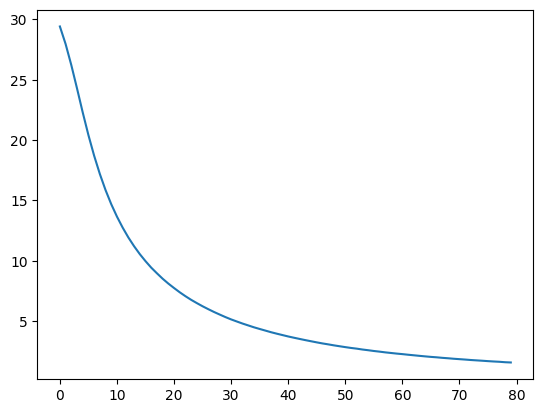

In [ ]:
sns.lineplot(x=list(range(len(train_losses))), y=train_losses);

In [ ]:
# Model Evaluation
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_test_pred_log = model(X_batch)
        y_test_pred = torch.argmax(y_test_pred_log, dim=1)

y_test_pred_np = y_test_pred.squeeze().cpu().numpy()

In [ ]:
acc = accuracy_score(y_pred=y_test_pred_np, y_true=y_test)
print(f"The accuracy of the model is {np.round(acc, 3) * 100}")

The accuracy of the model is 63.800000000000004


In [ ]:
most_common_cnt = Counter(y_test).most_common()[0][1]
print(f"Naive Classifier: {np.round(most_common_cnt / len(y_test) * 100, 1)} %")

Naive Classifier: 41.0 %


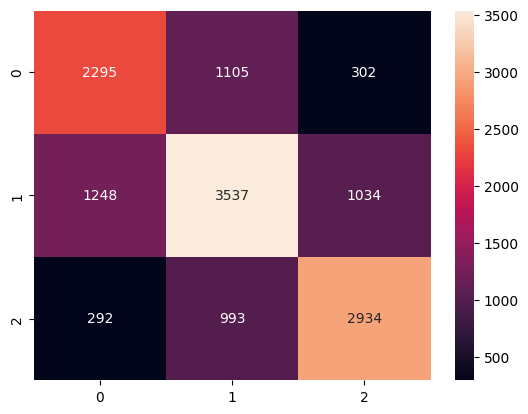

In [ ]:
# Confusion Matrix
sns.heatmap(confusion_matrix(y_test_pred_np, y_test), annot=True, fmt=".0f");

#[02] GloVe

In [ ]:
import torch
import torchtext.vocab as vocab

/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [ ]:
glove = vocab.GloVe(name='6B', dim=100)

.vector_cache/glove.6B.zip: 862MB [02:40, 5.38MB/s]                           
100%|█████████▉| 399999/400000 [00:37<00:00, 10694.08it/s]


In [ ]:
# number of words and embeddings
glove.vectors.shape

torch.Size([400000, 100])

In [ ]:
# get an embedding vector
def get_embedding_vector(word):
    word_index = glove.stoi[word]
    emb = glove.vectors[word_index]
    return emb

get_embedding_vector('chess')

tensor([ 3.7635e-01,  5.4567e-01,  3.0534e-01,  9.0395e-01, -8.8172e-02,
         6.2945e-01,  4.0376e-01, -8.1160e-01, -1.9370e-01, -3.1395e-01,
        -1.6067e-02, -6.8291e-01, -1.2400e-02, -2.0827e-01, -1.0267e+00,
         1.4386e+00,  5.1816e-01,  2.0026e-01, -8.3672e-04, -2.9563e-01,
        -7.5463e-01,  1.9618e-01,  6.0900e-01,  3.6774e-01,  7.2106e-01,
        -8.6832e-01, -2.1198e-01, -4.3051e-01,  7.1873e-01,  7.5019e-01,
        -6.0245e-01,  7.5618e-01, -5.5033e-01, -6.6510e-01,  5.3047e-01,
        -2.2391e-01, -9.2297e-01,  6.2659e-01, -2.5183e-01, -8.2082e-01,
        -1.6507e-01,  2.9234e-01, -2.6373e-01, -8.1124e-01, -4.0006e-02,
        -1.3341e-01,  2.9392e-01, -4.4894e-01,  5.6080e-02,  3.9754e-01,
        -6.8598e-01, -3.4001e-01, -1.1112e-02,  7.5445e-01,  2.8091e-01,
        -1.4169e+00,  2.7837e-01,  3.4846e-01,  1.3482e-01,  1.2508e+00,
        -8.0446e-02,  4.9207e-01, -7.0844e-01,  6.3239e-01, -3.8550e-01,
        -4.9367e-01, -2.1818e-01,  7.6461e-01,  6.3

In [ ]:
glove.stoi['woman']

787

In [ ]:
glove.stoi['man']

300

In [ ]:
glove.itos[787]

'woman'

In [ ]:
get_embedding_vector('chess').shape

torch.Size([100])

In [ ]:
# find closest words from input word
def get_closest_words_from_word(word, max_n=5):
    word_emb = get_embedding_vector(word)
    distances = [(w, torch.dist(word_emb, get_embedding_vector(w)).cpu().item()) for w in glove.itos]
    dist_sort_filt = sorted(distances, key=lambda x: x[1])[:max_n]
    return dist_sort_filt

In [ ]:
get_closest_words_from_word('chess')

[('chess', 0.0),
 ('backgammon', 4.379469394683838),
 ('grandmasters', 4.56368350982666),
 ('grandmaster', 4.613785743713379),
 ('scrabble', 4.677640438079834)]

In [ ]:
# find closest words from embedding
def get_closest_words_from_embedding(word_emb, max_n=5):
    distances = [(w, torch.dist(word_emb, get_embedding_vector(w)).cpu().item()) for w in glove.itos]
    dist_sort_filt = sorted(distances, key=lambda x : x[1])[:max_n]
    return dist_sort_filt

In [ ]:
# find word analogies
# e.g. King is to Queen like Man is to Woman
def get_word_analogy(word1, word2, word3, max_n=5):
    # logic w1 = king, ...
    # w1 - w2 + w3 ---> w4
    word1_emb = get_embedding_vector(word1)
    word2_emb = get_embedding_vector(word2)
    word3_emb = get_embedding_vector(word3)
    word4_emb = word1_emb - word2_emb + word3_emb
    analogy = get_closest_words_from_embedding(word4_emb)
    return analogy

In [ ]:
get_word_analogy(word1 = 'sister', word2="brother", word3='nephew')

[('sister', 2.5398471355438232),
 ('niece', 2.700707197189331),
 ('granddaughter', 3.272900342941284),
 ('sister-in-law', 3.652935743331909),
 ('cousin', 3.657327651977539)]

In [ ]:
import pandas as pd
from plotnine import ggplot, aes, geom_text, labs
from sklearn.manifold import TSNE
import torchtext.vocab as vocab
import torch

In [ ]:
glove_dim = 100
glove = vocab.GloVe(name='6B', dim=glove_dim)

def get_embedding_vector(word):
    word_index = glove.stoi[word]
    emb = glove.vectors[word_index]
    return emb

In [ ]:
def get_closest_words_from_word(word, max_n=5):
    word_emb = get_embedding_vector(word)
    distances = [(w, torch.dist(word_emb, get_embedding_vector(w)).cpu().item()) for w in glove.itos]
    dist_sort_filt = sorted(distances, key=lambda x: x[1])[:max_n]
    return [item[0] for item in dist_sort_filt]

In [ ]:
get_closest_words_from_word(word='chess', max_n=10)

['chess',
 'backgammon',
 'grandmasters',
 'grandmaster',
 'scrabble',
 'billiards',
 'xiangqi',
 'kasparov',
 'snooker',
 'olympiad']

In [ ]:
words = []
categories = ['numbers', 'algebra', 'music', 'science', 'technology']

df_word_cloud = pd.DataFrame({
    'category':[],
    'word':[]
})

for category in categories:
    print(category)
    closest_words = get_closest_words_from_word(word=category, max_n=20)
    temp = pd.DataFrame({
        'category':[category] * len(closest_words),
        'word':closest_words
    })
    df_word_cloud = pd.concat([df_word_cloud, temp], ignore_index=True)

numbers
algebra
music
science
technology


In [ ]:
df_word_cloud

,category,word
0,numbers,numbers
1,numbers,number
2,numbers,though
3,numbers,instance
4,numbers,fact
...,...,...
95,technology,applications
96,technology,innovations
97,technology,developing
98,technology,research


In [ ]:
# get the 100 dimension word embedding for all words
n_rows = df_word_cloud.shape[0]
n_cols = glove_dim
x = torch.empty((n_rows, n_cols))
for i in range(n_rows):
    current_word = df_word_cloud.loc[i, 'word']
    x[i, :] = get_embedding_vector(current_word)
    print(f"{i}: {current_word}")

In [ ]:
x

tensor([[-0.4527,  0.9526,  0.4424,  ...,  0.0189,  0.0202,  0.0712],
        [-0.4549,  0.7088,  0.0523,  ..., -0.4229,  0.5860, -0.4241],
        [-0.2005,  0.3965,  0.4197,  ..., -0.0372,  0.1970,  0.0616],
        ...,
        [-0.2516,  0.7325,  0.3079,  ..., -0.8932,  1.2976, -0.0490],
        [-0.1638,  0.5235, -0.7395,  ..., -0.8825,  0.7413,  0.5060],
        [-0.6327,  0.5771, -0.3891,  ..., -0.5037,  1.0252,  0.1204]])

In [ ]:
x.shape

torch.Size([100, 100])

In [ ]:
tsne = TSNE(n_components=2)
x_tsne = tsne.fit_transform(x.cpu().numpy())

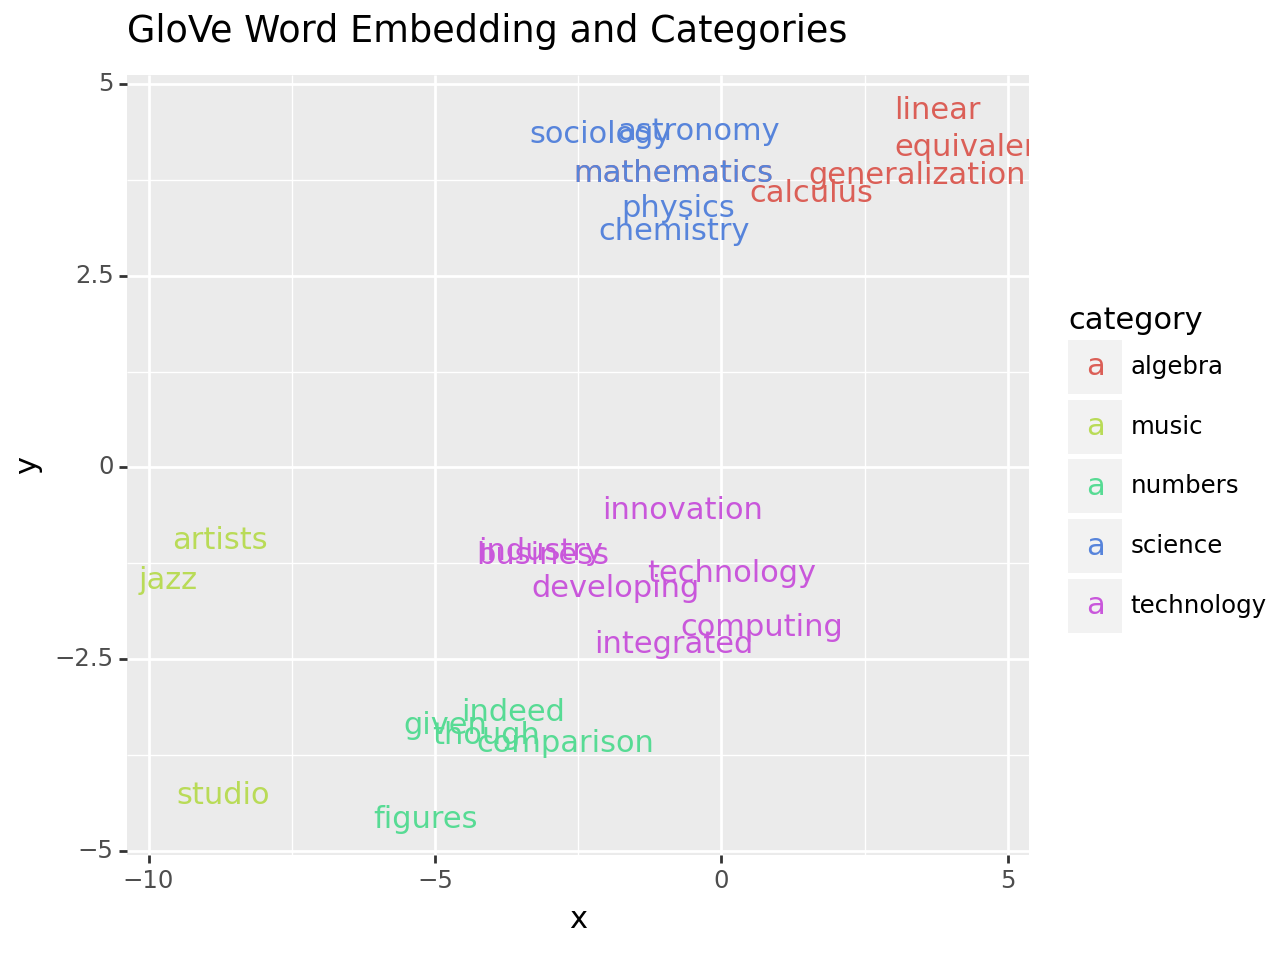

<Figure Size: (640 x 480)>

In [ ]:
df_word_cloud['x'] = x_tsne[:, 0]
df_word_cloud['y'] = x_tsne[:, 1]

ggplot(data=df_word_cloud.sample(25)) \
+ aes(x='x', y='y', label='word', color='category') \
+ geom_text() + labs(title='GloVe Word Embedding and Categories')

# [03] Sentiment with Embedding

In [ ]:
!pip install sentence_transformers

In [4]:
import numpy as np
import pandas as pd
import pickle
from collections import Counter
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sentence_transformers import SentenceTransformer

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [5]:
# import data
twitter_file = 'Tweets.csv'
df = pd.read_csv(twitter_file).dropna()
df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [9]:
cat_id = {'neutral':1, 'negative':0, 'positive':2}

df['class'] = df['sentiment'].map(cat_id)

In [10]:
# Hyperparameters
BATCH_SIZE = 128
NUM_EPOCHS = 80
MAX_FEATURES = 10

In [7]:
# Embedding Model
emb_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v1')

sentences = ['Each sentence is converted']
embeddings = emb_model.encode(sentences)
print(embeddings.squeeze().shape)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/9.90k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/591 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

(768,)


In [8]:
# prepare X and y
X = emb_model.encode(df['text'].values)

with open('tweets_X.pkl', 'wb') as output_file:
    pickle.dump(X, output_file)

In [11]:
with open('tweets_X.pkl', 'rb') as input_file:
    X = pickle.load(input_file)

In [12]:
y = df['class'].values

In [13]:
# Train Val Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=123)

In [14]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(13740, 768) (13740, 768) (13740,) (13740,)


In [15]:
class SentimentData(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = torch.Tensor(X)
        self.y = torch.Tensor(y).type(torch.LongTensor)
        self.len = len(self.X)

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [17]:
train_ds = SentimentData(X=X_train, y=y_train)
test_ds = SentimentData(X_test, y_test)

# Dataloader
train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=15000)

In [18]:
# Model
class SentimentModel(nn.Module):
    def __init__(self, NUM_FEATURES, NUM_CLASSES, HIDDEN=10):
        super().__init__()
        self.linear = nn.Linear(NUM_FEATURES, HIDDEN)
        self.linear2 = nn.Linear(HIDDEN, NUM_CLASSES)
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.log_softmax(x)
        return x

In [20]:
# Model, Loss and Optimizer
model = SentimentModel(NUM_FEATURES = X_train.shape[1], NUM_CLASSES=3)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())

In [ ]:
# Model Training
train_losses = []
for e in range(NUM_EPOCHS):
    curr_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred_log = model(X_batch)
        loss = criterion(y_pred_log, y_batch.long())

        curr_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_losses.append(curr_loss)
    print(f"Epoch {e}, Loss: {curr_loss}")

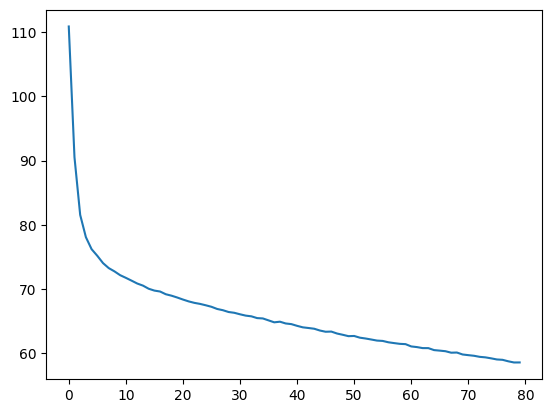

In [23]:
sns.lineplot(x=list(range(len(train_losses))), y=train_losses);

In [24]:
# Model Evaluation
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_test_pred_log = model(X_batch)
        y_test_pred = torch.argmax(y_test_pred_log, dim=1)

In [25]:
y_test_pred_np = y_test_pred.squeeze().cpu().numpy()

In [26]:
acc = accuracy_score(y_pred=y_test_pred_np, y_true=y_test)
print(f"The accuracy of the model is {np.round(acc, 3)*100} %")

The accuracy of the model is 68.2 %


In [27]:
most_common_cnt = Counter(y_test).most_common()[0][1]
print(f"Naive ClassifierL {np.round(most_common_cnt / len(y_test)* 100, 1)} %")

Naive ClassifierL 41.0 %
